In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
import scipy.stats as stats
from Modules.wine_transformations import remove_outliers, apply_normalization_techniques, map_affects
data = pd.read_csv("../DataThon/wine-quality-white-and-red.csv")
reds = data[data['type'] == 'red']
whites = data[data['type'] == 'white']

## How we are calculating our metrics
Each metric is calculated by utilizing a weighted sum, as shown below;
Residual sugar corresponds to $s_{r}$, density $d_{r}$, fixed acidity $fa_{r}$, pH as $pH_{r}$, alcohol as $a_{r}$, free sulfur dioxide $so_{r}$, chlorides $c_{r}$, citric acid $ca_{r}$ for a given row $r$

Sweetness is represented as the weighted sum of residual sugars, density and alcohol content.
$$sweetness = 2s_{r} + 0.5d_{r} + 10-a_{r}$$ 

Acidity is represented as the weighted sum of how the pH of the wine compares to the average, the chlorides and the fixed acidity if it goes past a certain threshhold.
$$acidity = 4(1-pH_{r}/3.05) + 0.75c_{r} + 4(fa_{r}-9)$$

Crispenss is represented as the weighted sum of the fixed acidity and the citric acid.
$$crispness = 4fa_{r} + 2ca_{r}$$

Fruitiness is represented as the weighted sum of the molecular sulfur dioxide, how the pH of the wine compares to the average and the citric acid. Additionally, molecular sulfur dioxide is represented as $mso_{r}$
$$ mso_{r} = \frac{so_{r}}{1 + 10^{pH_{r}-1.8}} $$
$$fruitiness = 10(mso_{r} - 0.6) + 2(1 - pH_{r}/3.05) + 2 ca_{r}$$

Lastly, dryness is the inverse of sweetness.

$$ dryness = sweetness^{-1} $$

## Checking the distributions of our variables
Before we jump head-first into utilizing the wine quality data set, we are going to explore the variables of interest. Additionally, since wine properties vary by red and white, we will be transforming each separately after our intial peak. Below are initial distributions of variables of interest for our wine data. 

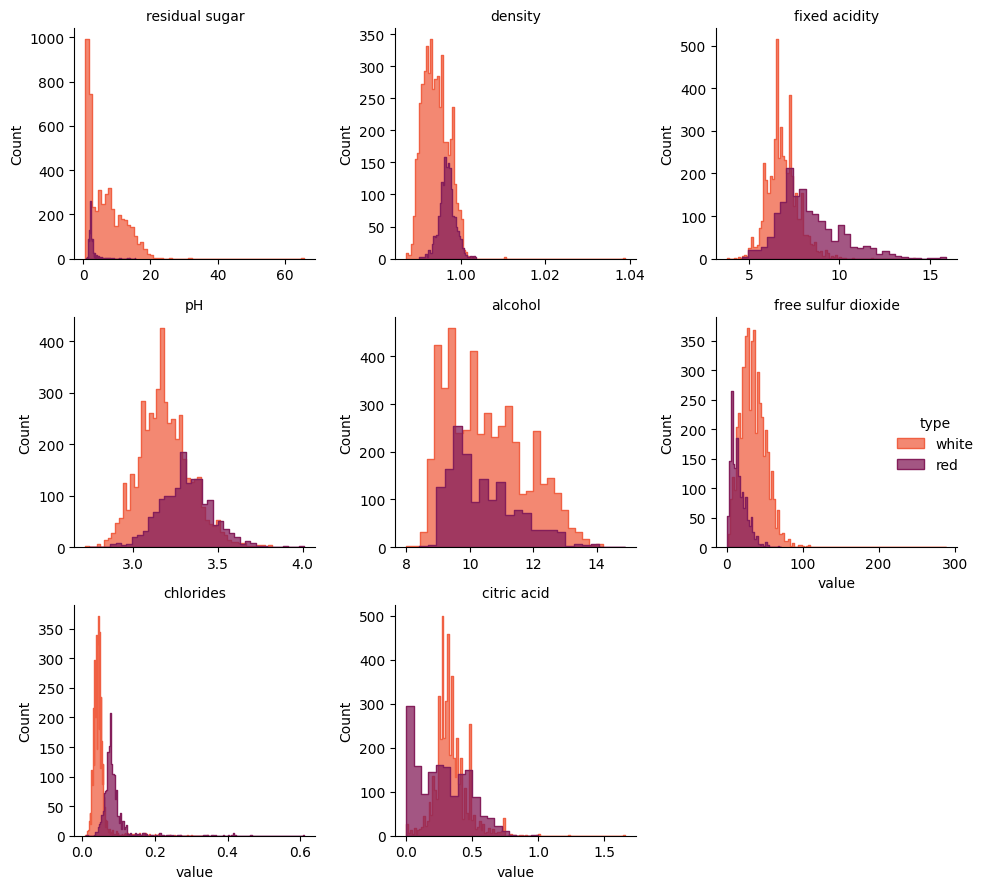

In [3]:
variables = ['residual sugar', 'density', 'fixed acidity', 'pH', 'alcohol', 'free sulfur dioxide', 'chlorides', 'citric acid']
wine_data_long = data.melt(id_vars='type', value_vars=variables, var_name='variable', value_name='value')

g = sns.FacetGrid(wine_data_long, col="variable", hue="type", palette="rocket_r", col_wrap=3, sharex=False, sharey=False)
g = (g.map(sns.histplot, "value", element="step").add_legend())

g.set_titles("{col_name}")
g.fig.tight_layout()

plt.show()

## Outlier removal
As noticeable in residual sugar, density, free sulfur dioxide, chlorides, and citric acid, many outliers are prevalent. For our data, we utilized two separate outlier removal techniques: IQR and Z score thresholds.

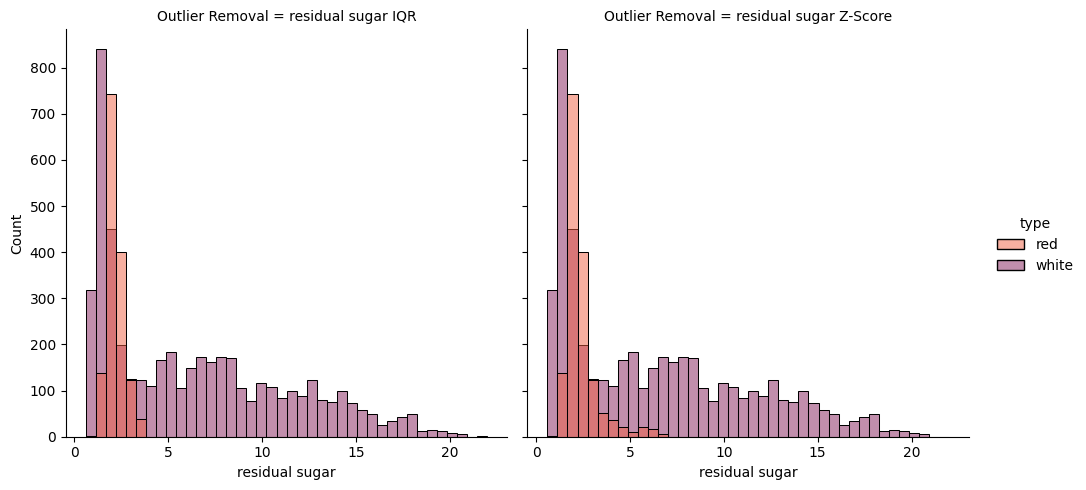

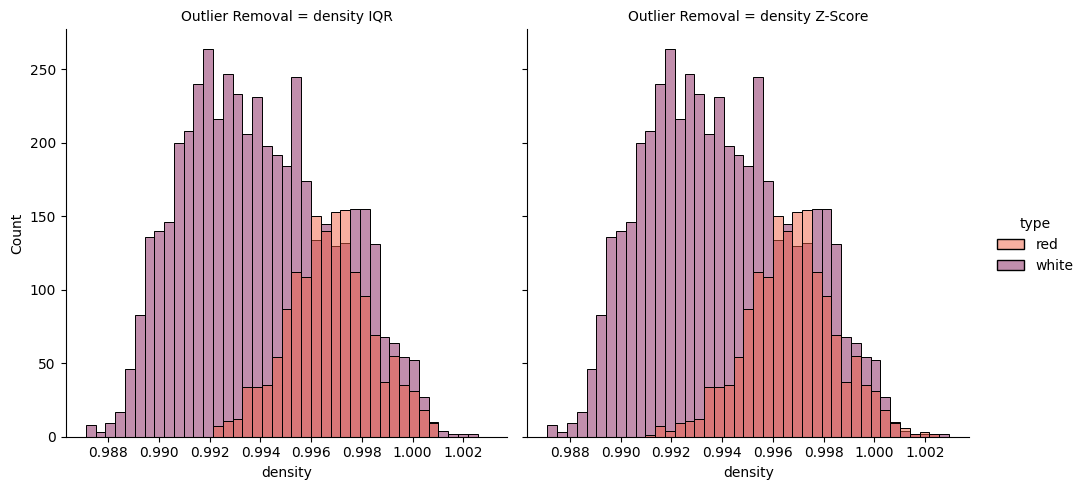

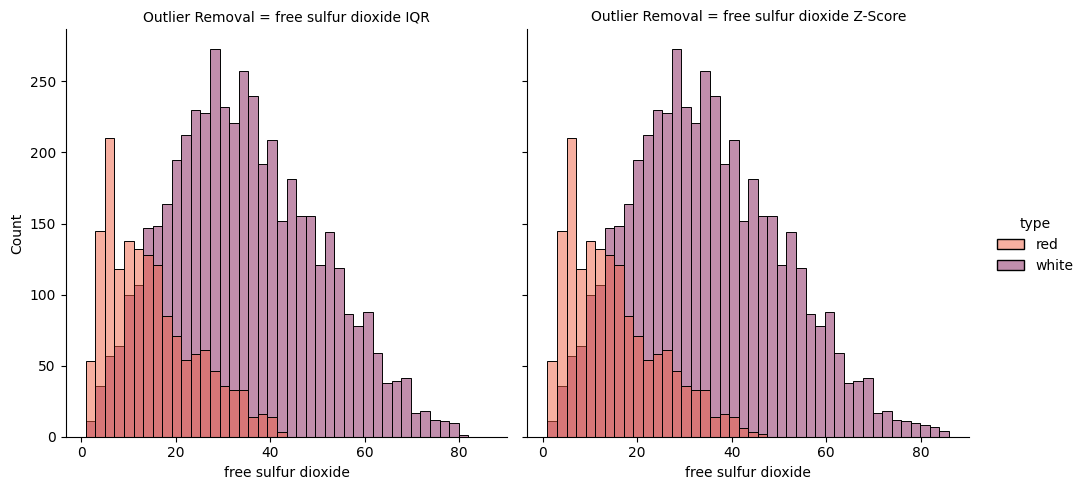

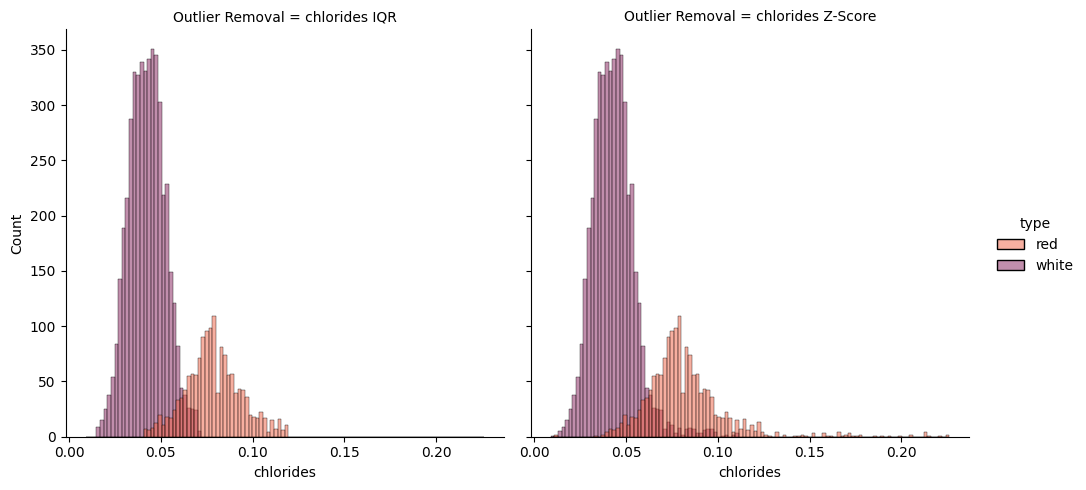

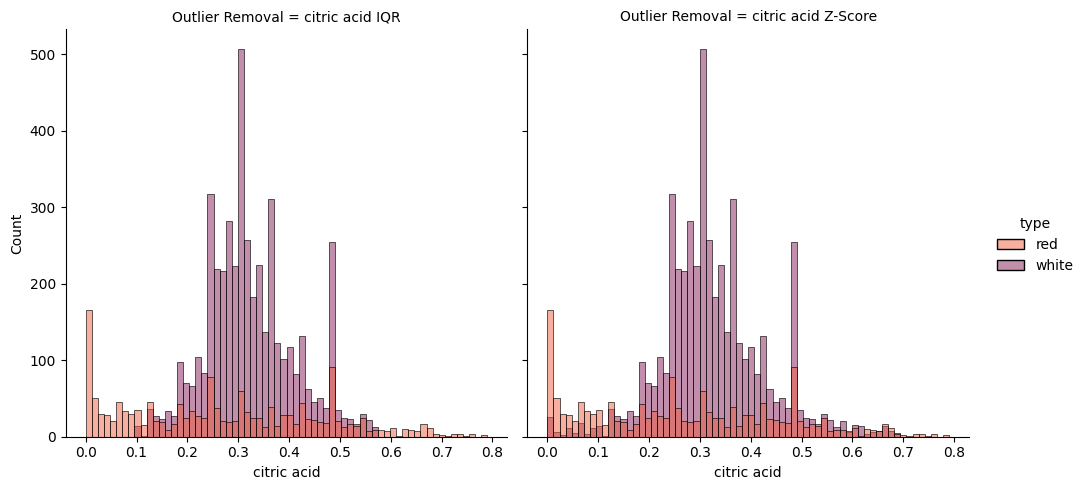

In [4]:
outlier_vars = ['residual sugar', 'density', 'free sulfur dioxide', 'chlorides', 'citric acid']
outlier_removal_types = ['IQR', 'Z-Score']
IQR = []
Z_SCORE = []
for i in range(5):
    feature = outlier_vars[i]
    IQR.append([remove_outliers(reds, feature, True, 1.5), remove_outliers(whites, feature, True, 1.5)])
    Z_SCORE.append([remove_outliers(reds, feature, False, 3), remove_outliers(whites, feature, False, 3)])

final_outputs = []

for index in range(5):
    final_outputs.append([pd.concat(IQR[index], axis=0), pd.concat(Z_SCORE[index], axis=0)])
    
for i in range(5):
    map_affects(final_outputs[i], outlier_vars[i], outlier_removal_types, 'Outlier Removal')

Evidently, outliers that were once heavily represented are now removed through both the usage of IQR and Z-score. However, IQR performed marginally better, therefore we will be utilizing the data that has had outliers removed via IQR.

In [5]:
# Remove all outliers from features present in outlier vars
for feature in outlier_vars:
    reds = remove_outliers(reds, feature, True, 1.5)
    whites = remove_outliers(whites, feature, True, 1.5)

## Normalization
In addition to outlier removal, we will be normalizing our variables of interest before applying any extra transformations or using them in interaction calculations. 

In [6]:
normalizer_var = ['residual sugar', 'density', 'free sulfur dioxide', 'chlorides', 'citric acid']
normalizer_types = ['min-max', 'inv-log', 'robust', 'z-score']
MIN_MAX = []
# LOG = []
INV_LOG = []
ROBUST = []
Z_SCORE = []

for i in range(5):

    feature = normalizer_var[i]
    MIN_MAX.append([apply_normalization_techniques(reds, feature, 'min-max'), apply_normalization_techniques(whites, feature, 'min-max')])
    # LOG.append([apply_normalization_techniques(reds, feature, 'log'), apply_normalization_techniques(whites, feature, 'log')])
    INV_LOG.append([apply_normalization_techniques(reds, feature, 'inv-log'),apply_normalization_techniques(whites, feature, 'inv-log')])
    ROBUST.append([apply_normalization_techniques(reds, feature, 'robust'), apply_normalization_techniques(whites, feature, 'robust')])
    Z_SCORE.append([apply_normalization_techniques(reds, feature, 'z-score'), apply_normalization_techniques(whites, feature, 'z-score')])

final_outputs=[]
for index in range(5):
    final_outputs.append([pd.concat(MIN_MAX[index], axis=0),  pd.concat(INV_LOG[index], axis=0), pd.concat(ROBUST[index], axis=0), pd.concat(Z_SCORE[index], axis=0)])
    # pd.concat(LOG[index], axis=0),
  

In [7]:
map_affects(final_outputs[0], normalizer_var[0], normalizer_types, 'Normalization')  

: 

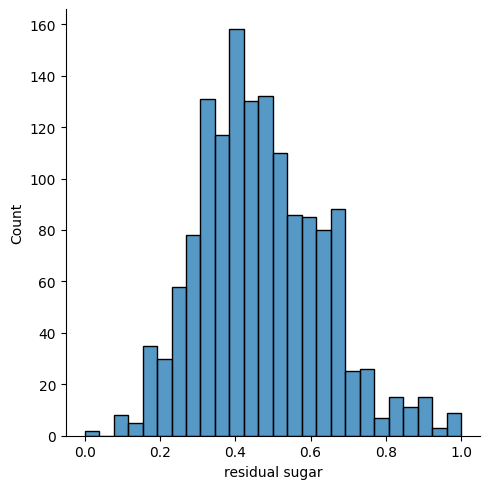

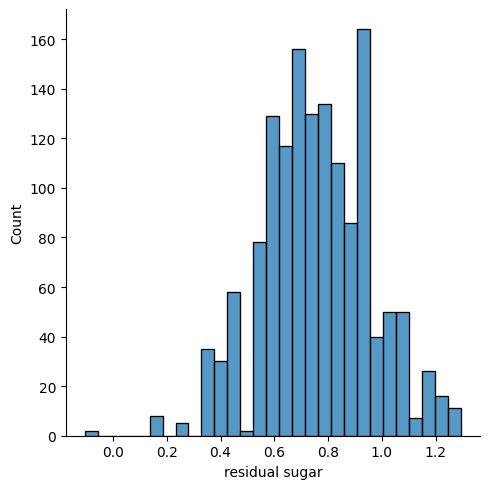

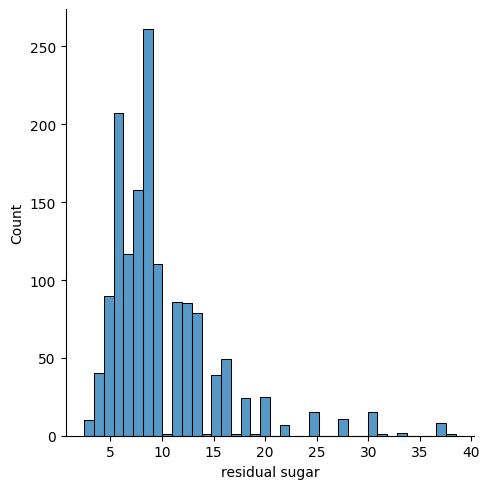

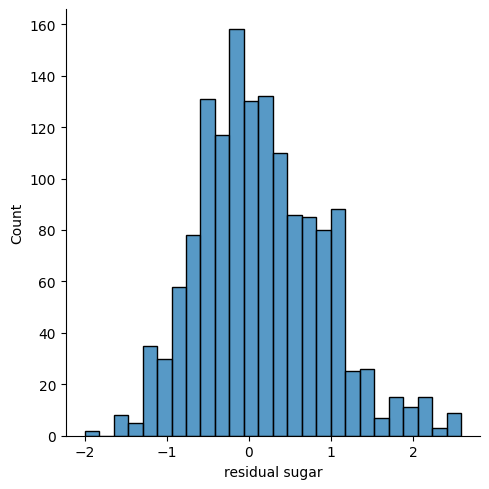

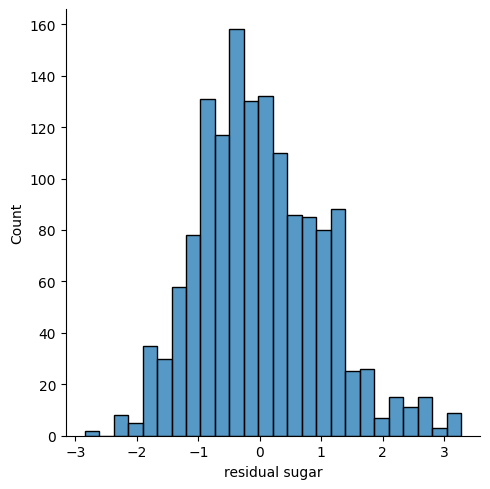

In [ ]:
data = pd.read_csv("../DataThon/wine-quality-white-and-red.csv")
reds = data[data['type'] == 'red']
whites = data[data['type'] == 'white']

normalization_methods = ["min-max", "log", "inv-log", "robust", "z-score"]
frames = []

reds_iqr = remove_outliers(reds, 'residual sugar', True, 1.5)
reds_Z = remove_outliers(reds, 'residual sugar', False, 3)

# map_affects([reds_iqr, reds_Z], 'residual sugar', ['IQR', 'Z Score'], 'Outlier Removal')

for method in normalization_methods:
    frames.append(apply_normalization_techniques(reds_iqr, 'residual sugar', method))
# counter = 1

# for frame in frames:

#     stat, p = stats.shapiro(frame['residual sugar'].to_list())
#     print('Statistics=%.3f, p=%.3f' % (stat, p))

#     # Interpretation
#     alpha = 0.05
#     if p > alpha:
#         print(f'Sample looks Gaussian (fail to reject H0) Frame number: {counter}')
#     else:
#         print(f'Sample does not look Gaussian (reject H0) Frame number: {counter}')
    
#     counter += 1

sns.displot(frames[0], x='residual sugar')
sns.displot(frames[1], x='residual sugar')
sns.displot(frames[2], x='residual sugar')
sns.displot(frames[3], x='residual sugar')
sns.displot(frames[4], x='residual sugar')

# stats.probplot(frames[3]['residual sugar'], dist='norm',plot=plt)

# stats.probplot(frames[0]['residual sugar'], dist='norm',plot=plt)

# stats.probplot(frames[1]['residual sugar'], dist='norm',plot=plt)

plt.show()
# map_affects(frames, 'residual sugar', normalization_methods, 'normalization')

In [ ]:
wine_data = pd.read_csv('../DataThon/wine-quality-white-and-red.csv')
wine_data.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,white,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,white,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


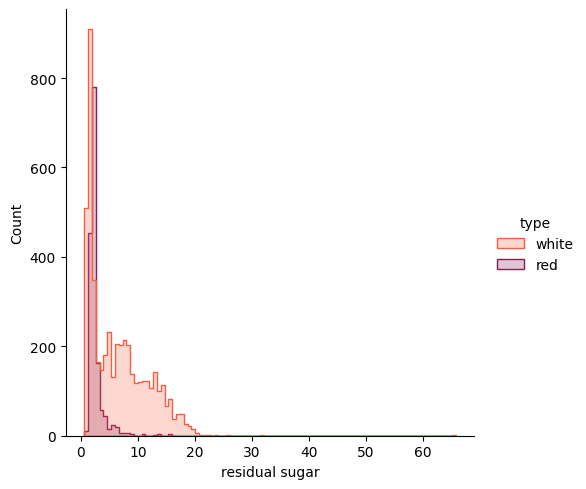

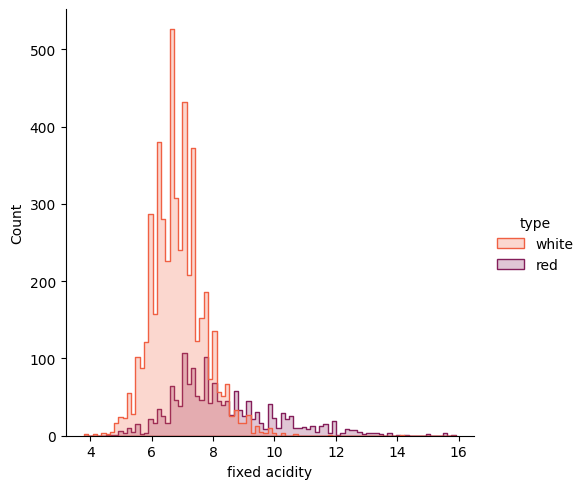

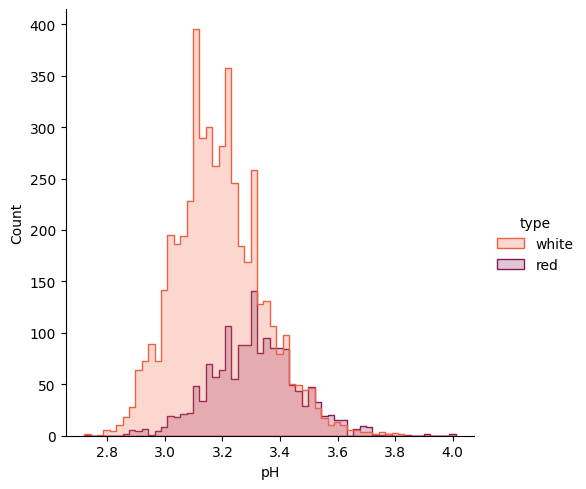

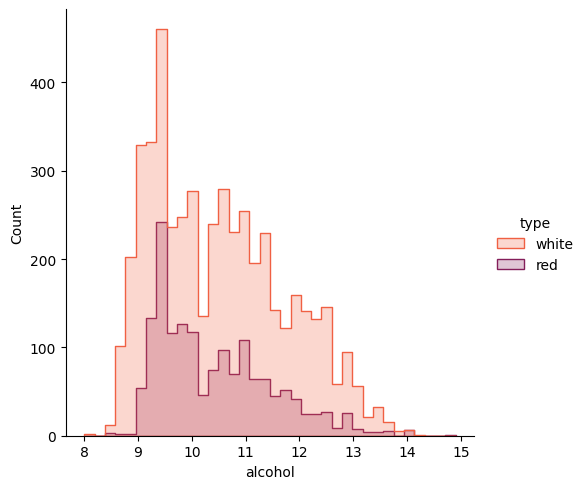

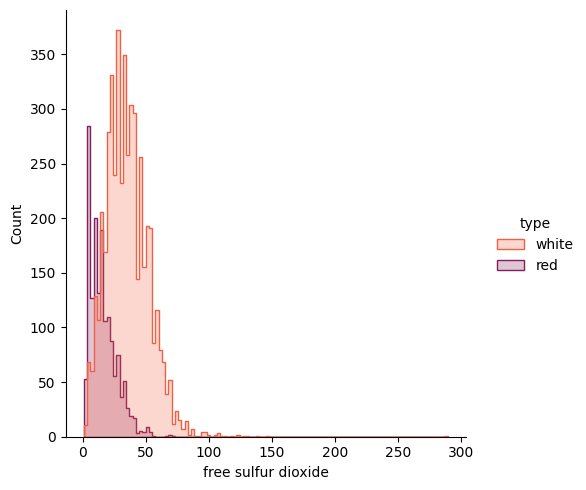

In [ ]:
sns.displot(wine_data, x='residual sugar', hue='type', palette='rocket_r', element='step')
sns.displot(wine_data, x='fixed acidity', hue='type', palette='rocket_r', element='step')
sns.displot(wine_data, x='pH', hue='type', palette='rocket_r', element='step')
sns.displot(wine_data, x='alcohol', hue='type', palette='rocket_r', element='step')
sns.displot(wine_data, x='free sulfur dioxide', hue='type', palette='rocket_r', element='step')

## Applying the box-cox and yeojohnson transformations to the data to create a more even distribution

1.8
8.1


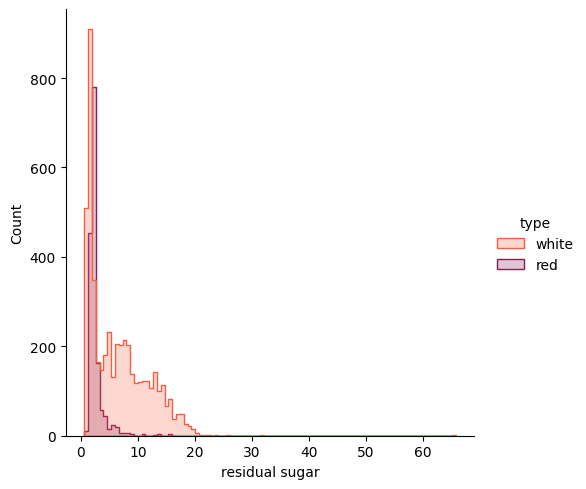

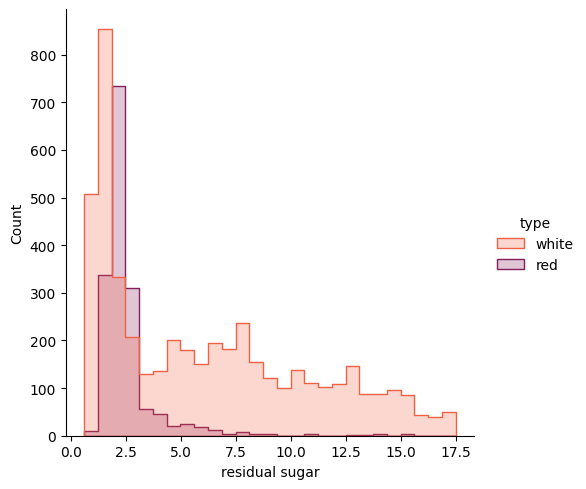

In [ ]:
# Outlier Removal
def remove_outliers(data, feature):
    quantile_1 = data[feature].quantile(0.25)
    quantile_3 = data[feature].quantile(0.75)
    IQR = quantile_3 - quantile_1

    lower_bound = quantile_1 - 1.5 * IQR
    upper_bound = quantile_3 + 1.5 * IQR
    print(quantile_1)
    print(quantile_3)
    
    

    data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

    return data

sns.displot(wine_data, x='residual sugar', hue='type', palette='rocket_r', element='step')
wine_data_without_outliers = remove_outliers(wine_data, 'residual sugar')
sns.displot(wine_data_without_outliers, x='residual sugar', hue='type', palette='rocket_r', element='step')
